<a href="https://colab.research.google.com/github/sanniel0315/python/blob/master/MNIST_%E5%8F%B2%E5%93%B2%E6%94%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # progress bar

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms # 資料前處理

In [ ]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('2.2.1+cu121', '0.17.1+cu121')

In [ ]:
!nvidia-smi

Mon Mar 18 10:49:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              29W /  70W |    165MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Prepare CIFAR10 Dataset

*   torch vision datasets: https://pytorch.org/vision/stable/datasets.html
*   CIFAR10 label

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [ ]:
# Define Parameters
NUM_CLASS = 10
# Class name and class mapping
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
class_map = {cls: i for i, cls in enumerate(class_names)}
print(class_map)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


#### torch.utils.data.Dataset

https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset

*   read **1** sample (img, label)
*   Convert to **Torch.Tensor**
* Datasets provided by torchvision https://pytorch.org/vision/stable/datasets.html


In [ ]:
# Download dataset
train_ds = torchvision.datasets.CIFAR10('data', # saved path
    train=True, # training or testing set
    download=True # download dataset from internet
)
val_ds = torchvision.datasets.CIFAR10('data',
    train=False,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Check your dataset
print('Number of training   samples:', len(train_ds))
print('Number of validation samples:', len(val_ds))

Number of training   samples: 50000
Number of validation samples: 10000


In [ ]:
# Random select a sample
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]

# Type of img and label
print(idx)
print(type(img), type(label))

24762
<class 'PIL.Image.Image'> <class 'int'>


img shape:  (32, 32, 3)
label:  1
class name:  automobile


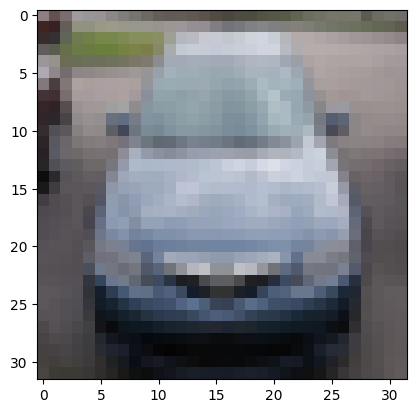

In [ ]:
# Convert to np.ndarray and show image
img_np = np.array(img)
print('img shape: ', img_np.shape)
print('label: ', label)
print('class name: ', class_names[label])
plt.imshow(img_np)
plt.show()

#### Data Proprocess



1.   Convert **PIL.Image** to **torch.FloatTensor** (張量)
  

*   Converts a **PIL Image or numpy.ndarray** (H, W, C) in the range [0, 255] to a **torch.FloatTensor** of shape (C, H, W) in the range [0.0, 1.0]

2.   TODO: Data Augmentation, ... etc


In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),]) # Convert to Tensor
    # ...

In [ ]:
# Build dataset with data preprocess
train_ds = torchvision.datasets.CIFAR10('data',
    train=True,
    download=True,
    transform=preprocess)
val_ds = torchvision.datasets.CIFAR10('data',
    train=False,
    download=True,
    transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


#### Combine Dataset with DataLoader

**torch.utils.data.DataLoader**: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

* form a **batch**
* data sampler
* reading order (shuffle)

In [ ]:
# Use DataLoader to generate minibatches
BATCH_SIZE = 256
train_dataloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=BATCH_SIZE)

Check shape of data

N: number of samples

C: channels

H: Height

W: Width

**PyTorch use channel first !**

In [ ]:
for x, y in train_dataloader:
    print("type ", type(x), type(y))
    print("Shape of x [N, C, H, W]: ", x.shape, x.dtype)
    print("Shape of y [N]: ", y.shape, y.dtype)
    break

type  <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of x [N, C, H, W]:  torch.Size([256, 3, 32, 32]) torch.float32
Shape of y [N]:  torch.Size([256]) torch.int64


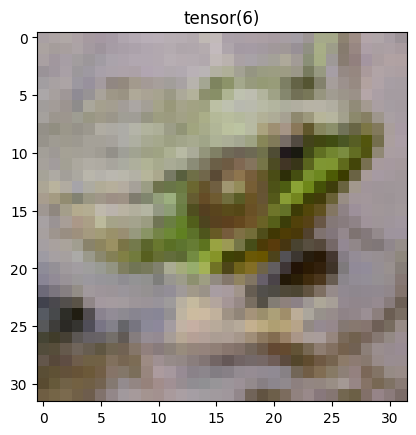

In [ ]:
# permute: [C, H, W] -> [H, W, C]
plt.imshow(x[0].permute(1, 2, 0)), y[0]
plt.title(str(y[0]))
plt.show()

#### Build Model

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

IMG_SIZE = 32

Using device: cuda


nn.Sequential

In [ ]:
model = nn.Sequential(
    nn.Flatten(), # (C, H, W) -> (C*H*W)
    nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64), # (C*H*W) -> (64)
    nn.ReLU(), # activation
    nn.Linear(64, 128), # (64) -> (128)
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASS), # (128) -> NUM_CLASS
)
model = model.to(device)

nn.Module Subclass

In [ ]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # (C, H, W) -> (C*H*W)
        self.base_model = nn.Sequential(
            nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64), # (C*H*W) -> (64)
            nn.ReLU(),
            nn.Linear(64, 128), # (64) -> (128)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASS), # (128) -> NUM_CLASS
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.base_model(x)
        return logits

In [ ]:
# init model and move to GPU device
model = NeuralNet().to(device)

In [ ]:
# Print basic model architecture
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (base_model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# Use torchsummary to print advanced info
import torchsummary

torchsummary.summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              ReLU-3                   [-1, 64]               0
            Linear-4                  [-1, 128]           8,320
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.85
Estimated Total Size (MB): 0.89
----------------------------------------------------------------


In [ ]:
# Use torchinfo to print advanced info
!pip install torchinfo

import torchinfo
torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [256, 10]                 --
├─Flatten: 1-1                           [256, 3072]               --
├─Sequential: 1-2                        [256, 10]                 --
│    └─Linear: 2-1                       [256, 64]                 196,672
│    └─ReLU: 2-2                         [256, 64]                 --
│    └─Linear: 2-3                       [256, 128]                8,320
│    └─ReLU: 2-4                         [256, 128]                --
│    └─Linear: 2-5                       [256, 128]                16,512
│    └─ReLU: 2-6                         [256, 128]                --
│    └─Linear: 2-7                       [256, 10]                 1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
Total mult-adds (M): 57.04
Input size (MB): 3.15
Forward/backward pass size (MB): 0.68
Params size (MB): 0.89
Estimated Total Size (MB): 4

#### Training: Optimizing the Model Parameters


In [ ]:
loss_fn = nn.CrossEntropyLoss() # Softmax + negative log likelihood loss (nn.NLLLoss)


In [ ]:
def train_epoch(dataloader, model, loss_fn,optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # model to train mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    # with torch.no_grad():
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

     # Compute prediction loss
    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

     # write to logs
    epoch_loss += loss.item()

    epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
     for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1)== y).sum().item()
    return epoch_loss/num_batches,epoch_correct/size

In [ ]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
  }
for epoch in tqdm(range(EPOCHS)):
   train_loss,train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer)
   val_loss, val_acc = test(val_dataloader, model, loss_fn)

   print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

   logs['train_loss'].append(train_loss)
   logs['train_acc'].append(train_acc)
   logs['val_loss'].append(val_loss)
   logs['val_acc'].append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.0118, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 0.0118, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 0.0117, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 3     train_loss: 0.0117, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 4     train_loss: 0.0117, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 5     train_loss: 0.0118, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 6     train_loss: 0.0118, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 7     train_loss: 0.0118, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 8     train_loss: 0.0117, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 9     train_loss: 0.0117, train_acc: 0.000     val_loss: 2.3052, val_acc: 0.121 


#### Logs

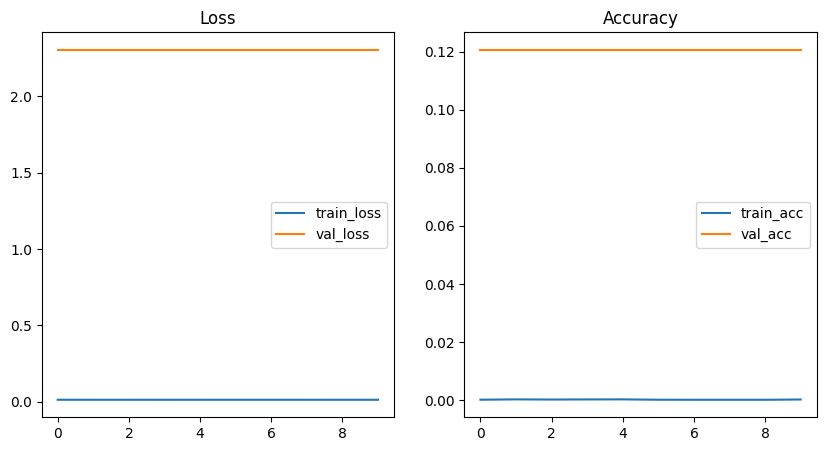

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Save Model

Saving & Loading Model (weights only)

**Recommended**

In [ ]:
# model parameters
model.state_dict()

OrderedDict([('base_model.0.weight',
              tensor([[ 0.0079,  0.0012, -0.0067,  ...,  0.0155,  0.0053, -0.0169],
                      [ 0.0034, -0.0137, -0.0115,  ...,  0.0008, -0.0007,  0.0180],
                      [-0.0099,  0.0074,  0.0160,  ...,  0.0048, -0.0006, -0.0034],
                      ...,
                      [ 0.0130, -0.0122,  0.0113,  ...,  0.0040, -0.0085,  0.0032],
                      [-0.0038, -0.0027,  0.0143,  ...,  0.0024,  0.0168, -0.0117],
                      [-0.0019,  0.0143, -0.0008,  ..., -0.0069, -0.0048, -0.0088]],
                     device='cuda:0')),
             ('base_model.0.bias',
              tensor([-0.0134,  0.0049, -0.0028,  0.0080, -0.0085, -0.0160,  0.0177, -0.0162,
                       0.0021, -0.0141, -0.0156,  0.0108, -0.0121,  0.0097, -0.0050, -0.0154,
                      -0.0085, -0.0090,  0.0098, -0.0175, -0.0133, -0.0161, -0.0163,  0.0031,
                      -0.0139, -0.0031, -0.0005,  0.0118, -0.0074, -0.0114

In [ ]:
PATH = './model_weights.pth'
# save weights
torch.save(model.state_dict(), PATH)

# load weights
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Saving & Loading Model (entire model)

In [ ]:
MODEL_PATH = './model.pth'
# save model
torch.save(model, MODEL_PATH)
# load model
model = torch.load(MODEL_PATH)

#### Evaluation

In [ ]:
# load model
model = NeuralNet()

model.load_state_dict(torch.load(PATH))
model.eval()

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (base_model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

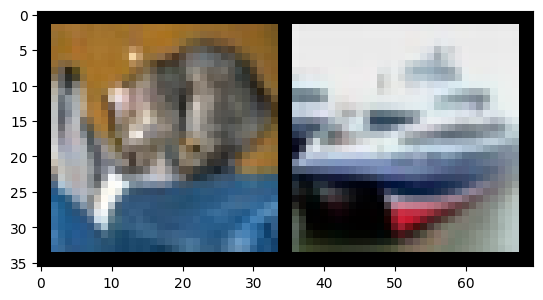

In [ ]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    images_grid = torchvision.utils.make_grid(images[:n])
    images_grid = images_grid.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    plt.imshow(images_grid.numpy())
    break

In [ ]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    break

# Predict by model
with torch.no_grad():
    pred = model(images) # predict logits
print('raw_prediction logtis', pred, pred.shape, sep="\n")

raw_prediction logtis
tensor([[ 0.1116, -0.0876,  0.0300,  0.0429, -0.0829,  0.0969,  0.0256, -0.0426,
         -0.0452,  0.0859],
        [ 0.0860, -0.0873,  0.0369,  0.0683, -0.0764,  0.0974,  0.0267, -0.0506,
         -0.0451,  0.0847]])
torch.Size([2, 10])


In [ ]:
pred_softmax = nn.Softmax(dim=1)(pred) # probabilities
print('prediction after softmax', pred_softmax, pred_softmax.shape, sep="\n")

prediction after softmax
tensor([[0.1100, 0.0902, 0.1014, 0.1027, 0.0906, 0.1084, 0.1010, 0.0943, 0.0941,
         0.1072],
        [0.1072, 0.0902, 0.1021, 0.1053, 0.0911, 0.1084, 0.1010, 0.0935, 0.0940,
         0.1071]])
torch.Size([2, 10])


In [ ]:
# max_prob: max probability of each samples
# predicted_cls: the index of max prob
max_prob, predicted_cls = torch.max(pred_softmax, dim=1)

In [ ]:
predicted_cls = pred_softmax.argmax(dim=1)

In [ ]:
pred_softmax.argmax(dim=1)

tensor([0, 5])

In [ ]:
print('GroundTruth: ', ' '.join(class_names[labels[j]] for j in range(n)))
print('Prediction: ', ' '.join(class_names[predicted_cls[j]] for j in range(n)))

GroundTruth:  cat ship
Prediction:  airplane dog
